In [1]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Pytorch
import torch as th
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
th.manual_seed(42)

In [3]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

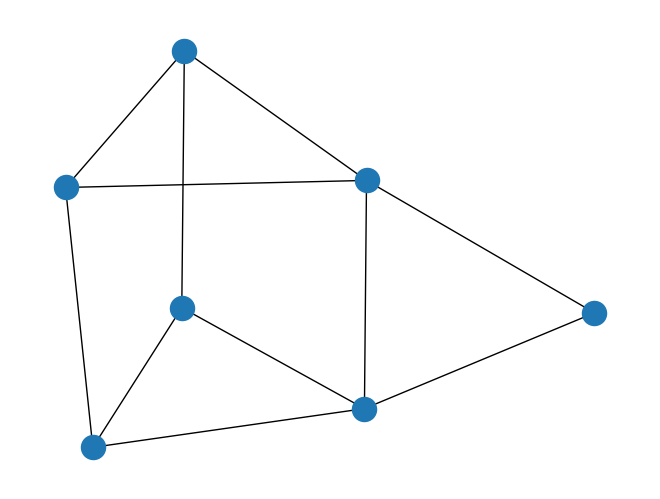

In [4]:
# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [5]:
def qaoa_graph(graph, layers=1):

    cost_H, mixer_H = qaoa.maxcut(graph)

    wires=range(graph.number_of_nodes()) # number of qubits required (wires) = number of nodes in the graph

    def qaoa_layer(gamma, alpha):

        qaoa.cost_layer(gamma, cost_H)
        qaoa.mixer_layer(alpha, mixer_H)

        return wires

    def circuit(params, **kwargs):

        for w in wires:
            qml.Hadamard(wires=w)

        qml.layer(qaoa_layer, layers, params[0], params[1])

        return qml.expval(qml.PauliZ(0))
    
    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit", wires=wires)

        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, diff_method="backprop", interface="torch")

        return cost(params)

    return hamiltonian


In [6]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_graph(graph=graphs[0], layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = th.tensor([[0.5], [0.5]], dtype=th.float32, requires_grad=True)

# Evaluate th QAOA instance just created with some angles.
print(cost(x))

tensor(0., dtype=torch.float64, grad_fn=<DotBackward0>)


In [7]:
# Set the number of layers in the QAOA ansatz.
layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz makes use of two parameters.
cell = nn.LSTMCell(1 + 2 * layers, hidden_size=2 * layers)

In [8]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_graph(g) for g in graphs]

In [9]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = th.cat([prev_cost, prev_params], dim=-1)

    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_h, new_c = cell(new_input, (prev_h, prev_c))
    new_params = new_h  # The output of LSTMCell is the new hidden state

    # Reshape the parameters to correctly match those expected by PennyLane
    _params = new_params.view(2, n_layers)

    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = _cost.view(1, 1).float()

    return [new_cost, new_params, new_h, new_c]


In [10]:
def recurrent_loop(graph_cost, layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = th.zeros((1, 1), dtype=th.float32)
    initial_params = th.zeros((1, 2 * layers), dtype=th.float32)
    initial_h = th.zeros((1, 2 * layers), dtype=th.float32)
    initial_c = th.zeros((1, 2 * layers), dtype=th.float32)

    # We perform five consecutive calls to 'rnn_iteration', thus creating the recurrent loop. 
    # More iterations lead to better results, at the cost of more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost, layers)
    out1 = rnn_iteration(out0, graph_cost, layers)
    out2 = rnn_iteration(out1, graph_cost, layers)
    out3 = rnn_iteration(out2, graph_cost, layers)
    out4 = rnn_iteration(out3, graph_cost, layers)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = 0.1 * out0[0] + 0.2 * out1[0] + 0.3 * out2[0] + 0.4 * out3[0] + 0.5 * out4[0]
    loss = loss.mean()  # Ensure it's a single scalar value

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

In [20]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    # Zero the gradients
    opt.zero_grad()

    # Evaluate the cost function
    loss = recurrent_loop(graph_cost)

    # Backward pass to compute gradients
    loss.backward()

    # Apply gradients and update the weights of the LSTM cell
    opt.step()

    return loss.item()

In [21]:
# Select an optimizer
opt = optim.Adam(cell.parameters(), lr=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = []
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss.append(loss)
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/20 - Loss: 0.0
 > Graph 6/20 - Loss: -5.960464122267695e-09
 > Graph 11/20 - Loss: 1.4901161193847656e-08
 > Graph 16/20 - Loss: -2.3841860041784457e-08
 >> Mean Loss during epoch: -6.407499364424751e-09
Epoch 2
 > Graph 1/20 - Loss: 8.940697071579962e-09
 > Graph 6/20 - Loss: 5.9604645663569045e-09
 > Graph 11/20 - Loss: 3.8743017682918435e-08
 > Graph 16/20 - Loss: -1.4901161193847656e-08
 >> Mean Loss during epoch: 4.619360050028831e-09
Epoch 3
 > Graph 1/20 - Loss: 0.0
 > Graph 6/20 - Loss: -2.3841860041784457e-08
 > Graph 11/20 - Loss: 1.1920929132713809e-08
 > Graph 16/20 - Loss: -8.940697071579962e-09
 >> Mean Loss during epoch: -3.129243986155217e-09
Epoch 4
 > Graph 1/20 - Loss: 0.0
 > Graph 6/20 - Loss: -4.470348358154297e-08
 > Graph 11/20 - Loss: 1.7881394143159923e-08
 > Graph 16/20 - Loss: -1.7881394143159923e-08
 >> Mean Loss during epoch: -3.874301912620836e-09
Epoch 5
 > Graph 1/20 - Loss: 0.0
 > Graph 6/20 - Loss: -1.4901161193847656e-08
 > Graph 11

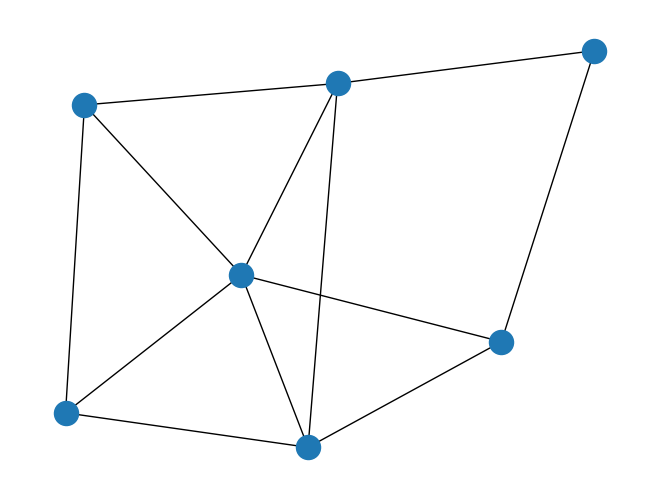

In [23]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
new_cost = qaoa_graph(new_graph)

nx.draw(new_graph)

In [24]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = th.zeros((2 * layers, 1), dtype=th.float32)
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(guess.view(2, layers)) for guess in guesses]

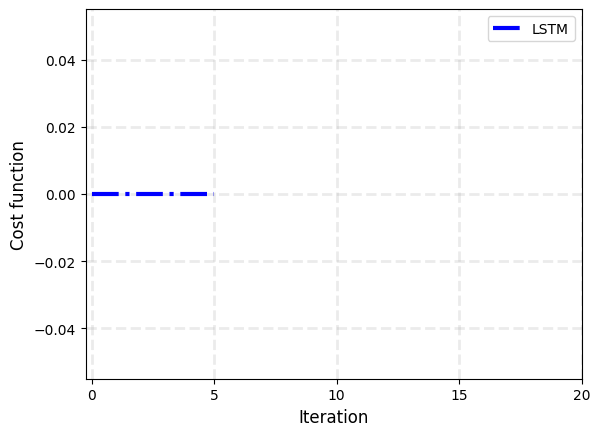

In [25]:
fig, ax = plt.subplots()

lstm_losses = [loss.detach().numpy() for loss in lstm_losses]

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20])
plt.show()

In [26]:
# Parameters are randomly initialized
x = th.tensor(np.random.rand(2, 1), requires_grad=True, dtype=th.float32)

# We set the optimizer to be a Stochastic Gradient Descent
opt = optim.SGD([x], lr=0.1)
step = 15

# Training process
steps = []
sdg_losses = []
for i in range(step):
    loss = new_cost(x)
    
    # Record the steps and losses
    steps.append(x.clone().detach())
    sdg_losses.append(loss.item())
    
    loss.backward()  # Compute the gradients
    opt.step()  # Perform the optimization step
    
    print(f"Step {i+1} - Loss = {loss.item()}")

print(f"Final cost function: {new_cost(x).item()}\nOptimized angles: {x.detach().numpy()}")

Step 1 - Loss = 0.0
Step 2 - Loss = 0.0
Step 3 - Loss = 2.9802322387695312e-08
Step 4 - Loss = -2.9802322387695312e-08
Step 5 - Loss = -2.9802322387695312e-08
Step 6 - Loss = 0.0
Step 7 - Loss = 0.0
Step 8 - Loss = -2.9802322387695312e-08
Step 9 - Loss = -2.9802322387695312e-08
Step 10 - Loss = -2.9802322387695312e-08
Step 11 - Loss = -2.9802322387695312e-08
Step 12 - Loss = 0.0
Step 13 - Loss = 0.0
Step 14 - Loss = -2.9802322387695312e-08
Step 15 - Loss = 2.9802322387695312e-08
Final cost function: 0.0
Optimized angles: [[0.8150544 ]
 [0.49809074]]


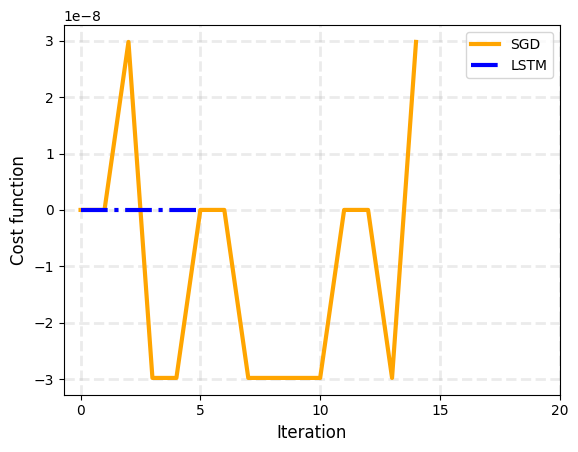

In [27]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20])
plt.show()